### Extract from OSM
The purpose of this script is to show how to go from a .osm.pbf file to a network format that GOSTnets will accept. 
Additional modifications in this script include: clipping the roads to an input polygon (here, kinshasa.shp), and slicing the roads DataFrame by a list of accepted road types, as tagged in OSM (see accepted_road_types list). 

In [1]:
import geopandas as gpd
import pandas as pd
import os, sys
# add to your system path the location of the LoadOSM.py and GOSTnet.py scripts
#sys.path.append(r'C:\Users\gost_\Desktop\lima\GOSTNets\GOSTNets')
#appending path to GOSTNets library in GOST_PublicGoods if this notebook is in the Implementations dir
sys.path.append(r'../../../GOSTNets/GOSTNets')
import GOSTnet as gn
import LoadOSM as losm
import importlib

networkx version: 2.2 
osmnx version: 0.9 


Define filepaths. To obtain the latest .osm.pbf file for your country/region of interest, visit: http://download.geofabrik.de/ 

In [2]:
#pth = r'C:\Users\gost_\Desktop\Lima'
pth = r'../../Peru_Lima_Optimization/test_data'
fil = r'peru-latest.osm.pbf'
f = os.path.join(pth, fil)

Using the loadOSM library, pass the filepath of the .osm.pbf to initiate a OSM_to_network class

In [3]:
lima = losm.OSM_to_network(f)

This generates a property of the class called 'roads_raw'. This is a raw geodataframe of the highway objects, extracted from the .osm.pbf. This is the starting point for our network

In [4]:
lima.roads_raw.infra_type.value_counts()

residential       214694
footway            34638
path               22200
unclassified       21416
track              19940
tertiary           18363
service            16187
secondary           9374
primary             7090
trunk               6849
living_street       5436
pedestrian          3766
steps               3251
road                2034
secondary_link      1084
primary_link        1004
corridor             753
motorway_link        645
trunk_link           579
motorway             513
tertiary_link        317
cycleway             255
construction         174
bridleway            144
raceway               49
bus_stop              27
proposed              14
yes                    2
piste                  1
Name: infra_type, dtype: int64

In [5]:
accepted_road_types = ['residential', 'unclassified', 'track','service','tertiary','road','secondary','primary','trunk','primary_link','trunk_link','tertiary_link','secondary_link']

We call the filerRoads method and pass it a list of acceptable road types

In [6]:
lima.filterRoads(acceptedRoads = accepted_road_types)

In [7]:
lima.roads_raw.infra_type.value_counts()

residential       214694
unclassified       21416
track              19940
tertiary           18363
service            16187
secondary           9374
primary             7090
trunk               6849
road                2034
secondary_link      1084
primary_link        1004
trunk_link           579
tertiary_link        317
Name: infra_type, dtype: int64

Here, we import a shapefile for our AOI and clip to its extent using standard Shapely and GeoPandas functions

In [8]:
shp = gpd.read_file(os.path.join(pth, 'VillaElSalvador_AOI.shp'))
#shp = shp.to_crs({'init':'epsg:4326'})
from shapely.ops import unary_union
shp_obj = unary_union(shp.geometry)

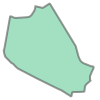

In [9]:
shp_obj

In [10]:
lima.roads_raw.count()

osm_id        318931
infra_type    318931
geometry      318931
dtype: int64

In [11]:
# count of roads that intersect the AOI
lima.roads_raw.geometry.intersects(shp_obj).value_counts()

False    315833
True       3098
dtype: int64

In [12]:
lima.roads_raw = lima.roads_raw.loc[lima.roads_raw.geometry.intersects(shp_obj) == True]

In [13]:
lima.roads_raw.count()

osm_id        3098
infra_type    3098
geometry      3098
dtype: int64

In [14]:
lima.roads_raw[:5]

,osm_id,infra_type,geometry
5686,39456802,primary,"LINESTRING (-76.94347740000001 -12.1805205, -7..."
6335,42432493,residential,"LINESTRING (-76.9116267 -12.2349531, -76.91152..."
12224,80913464,residential,"LINESTRING (-76.9596478 -12.2232528, -76.95906..."
12225,80913482,primary,"LINESTRING (-76.93026399999999 -12.2024961, -7..."
29878,111879454,residential,"LINESTRING (-76.92377860000001 -12.2195938, -7..."


having narrowed the GeoDataFrame to the roads we are interested in, we generate the RoadsGDF GeoDataFrame (by default this function saves the RoadsGDF GeoDataFrame into the object's roadsGPD property

In [15]:
lima.generateRoadsGDF(verbose = False)

In [16]:
lima.roadsGPD[:5]

,Wkt,id,infra_type,osm_id,key,length,u,v
0,"LINESTRING (-76.94347740000001 -12.1805205, -7...",1,primary,39456802,edge_1,0.107734,"(-76.9434774, -12.1805205)","(-76.9429819, -12.1813636)"
1,"LINESTRING (-76.94298190000001 -12.1813636, -7...",2,primary,39456802,edge_2,0.145671,"(-76.9429819, -12.1813636)","(-76.9423017, -12.1824977)"
2,"LINESTRING (-76.9116267 -12.2349531, -76.91152...",3,residential,42432493,edge_3,0.010957,"(-76.9116267, -12.2349531)","(-76.9115282, -12.2349737)"
3,"LINESTRING (-76.91152820000001 -12.2349737, -7...",4,residential,42432493,edge_4,0.034435,"(-76.9115282, -12.2349737)","(-76.9112309, -12.2350804)"
4,"LINESTRING (-76.91123090000001 -12.2350804, -7...",5,residential,42432493,edge_5,1.008291,"(-76.9112309, -12.2350804)","(-76.9026954, -12.2335763)"


With initialReadIn(), we transform this to a graph object

In [17]:
lima.initialReadIn()

We save this graph object down to file using gn.save()

In [18]:
#output_pth = r'/home/public/Data/PROJECTS/lima_optimization'
output_pth = r'../../../../lima_optimization_output'
gn.save(lima.network,'VES_graph',output_pth)